In [1]:
import os

os.environ["JAX_ENABLE_X64"] = "True"

import numpy as np

from deep_field_metadetect.jaxify.observation import ngmix_obs_to_dfmd_obs
from deep_field_metadetect.utils import (
    make_simple_sim,
)

In [2]:
import jax_galsim
import galsim

In [3]:
from deep_field_metadetect.metacal import (
    _render_psf_and_build_obs,
    get_max_gauss_reconv_psf,
)
from deep_field_metadetect.jaxify.jax_metacal import (
    get_jax_galsim_object_from_dfmd_obs,
    _jax_render_psf_and_build_obs,
    jax_get_max_gauss_reconv_psf,
)

# Try PSF matching by hand

In [4]:
stamp_size = 251
psf_size = 53

In [5]:
obs_w_non_jax, obs_d_non_jax, obs_dn_non_jax = make_simple_sim(
    seed=17,
    g1=0,
    g2=0,
    s2n=1e10,
    deep_noise_fac=1 / np.sqrt(30),
    deep_psf_fac=1,
    dim=stamp_size,
    dim_psf=psf_size,
    scale=0.2,
    buff=53,
    n_objs=5,
    return_dfmd_obs=False,
)

obs_w = ngmix_obs_to_dfmd_obs(obs_w_non_jax)
obs_d = ngmix_obs_to_dfmd_obs(obs_d_non_jax)
obs_dn = ngmix_obs_to_dfmd_obs(obs_dn_non_jax)

In [6]:
def get_galsim_object_from_ngmix_obs(obs, kind="image", rot90=0):
    """Make an interpolated image from an ngmix obs."""
    return galsim.InterpolatedImage(
        galsim.ImageD(
            np.rot90(getattr(obs, kind).copy(), k=rot90),
            wcs=obs.jacobian.get_galsim_wcs(),
        ),
        x_interpolant="lanczos15",
        _force_stepk=0.7529228667374486,
        _force_maxk=12.51728322914683,
    )

In [7]:
def match_psf(obs, reconv_psf):
    """Match the PSF on an ngmix observation to a new PSF."""
    wcs = obs.jacobian.get_galsim_wcs()
    image = get_galsim_object_from_ngmix_obs(obs, kind="image")
    psf = get_galsim_object_from_ngmix_obs(obs.psf, kind="image")

    psf_inv = galsim.Deconvolve(psf)

    ims_deconvolved = galsim.Convolve([image, psf_inv])
    ims = galsim.Convolve([ims_deconvolved, reconv_psf])

    ims = ims.drawImage(nx=obs.image.shape[1], ny=obs.image.shape[0], wcs=wcs).array
    ims_deconvolved = ims_deconvolved.drawImage(
        nx=obs.image.shape[1], ny=obs.image.shape[0], wcs=wcs
    ).array

    return (
        _render_psf_and_build_obs(ims, obs, reconv_psf, weight_fac=1),
        ims_deconvolved,
        psf_inv,
    )

In [8]:
def jax_match_psf(dfmd_obs, reconv_psf, nxy, nxy_psf):
    """Match the PSF on an dfmd observation to a new PSF."""
    wcs = dfmd_obs.aft._local_wcs
    image = get_jax_galsim_object_from_dfmd_obs(dfmd_obs, kind="image")
    psf = get_jax_galsim_object_from_dfmd_obs(dfmd_obs.psf, kind="image")

    psf_inv = jax_galsim.Deconvolve(psf)

    nk = 8

    ims_deconvolved = jax_galsim.Convolve(
        [image, psf_inv],
        gsparams=jax_galsim.GSParams(minimum_fft_size=nk, maximum_fft_size=nk),
    )
    ims = jax_galsim.Convolve(
        [ims_deconvolved, reconv_psf],
        gsparams=jax_galsim.GSParams(minimum_fft_size=nk, maximum_fft_size=nk),
    )

    ims = ims.withGSParams(
        minimum_fft_size=nxy * 4,
        maximum_fft_size=nxy * 4,
    )
    ims_drawim = ims.drawImage(nx=nxy, ny=nxy, wcs=wcs)
    ims = ims_drawim.array

    ims_deconvolved = ims_deconvolved.withGSParams(
        minimum_fft_size=nxy * 4,
        maximum_fft_size=nxy * 4,
    )
    ims_deconvolved = ims_deconvolved.drawImage(nx=nxy, ny=nxy, wcs=wcs).array

    return (
        _jax_render_psf_and_build_obs(ims, dfmd_obs, reconv_psf, nxy_psf, weight_fac=1),
        ims_deconvolved,
        psf_inv,
    )

### Check only on noise 

In [9]:
reconv_psf = jax_get_max_gauss_reconv_psf(obs_w, obs_d, nxy_psf=psf_size)
reconv_psf_ngmix = get_max_gauss_reconv_psf(obs_w_non_jax, obs_d_non_jax)

In [10]:
obs_reconvolved, ims_deconvolved, psf_inv = jax_match_psf(
    obs_w, reconv_psf, nxy=stamp_size, nxy_psf=psf_size
)
obs_reconvolved_numpy, ims_deconvolved_numpy, psf_inv_numpy = match_psf(
    obs_w_non_jax, reconv_psf_ngmix
)

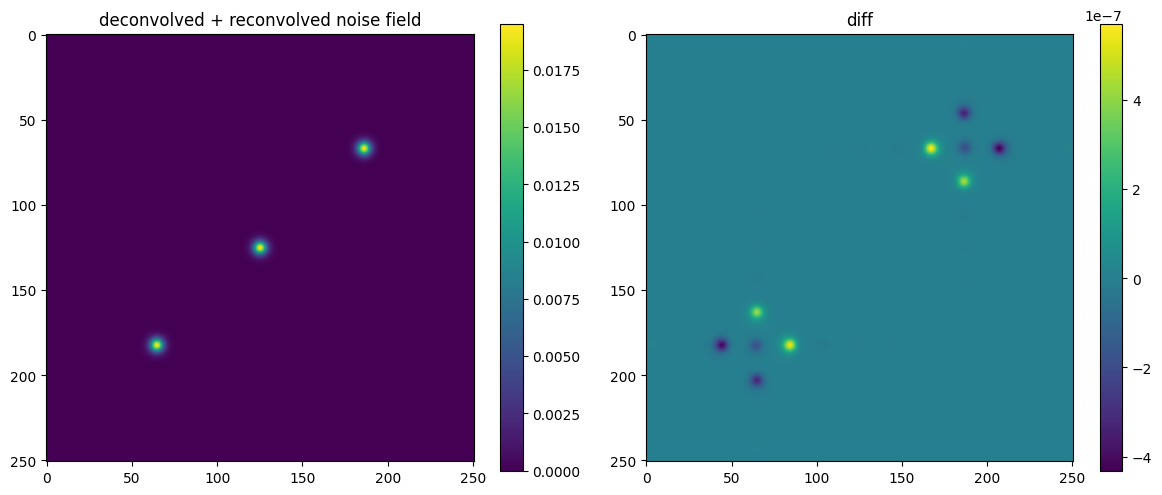

In [11]:
# compare reconvolved noise
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(obs_reconvolved.image)
fig.colorbar(im0, ax=axes[0])
axes[0].set_title("deconvolved + reconvolved noise field")

mask = obs_reconvolved.image

im1 = axes[1].imshow(obs_reconvolved.image - obs_reconvolved_numpy.image)
fig.colorbar(im1, ax=axes[1])
axes[1].set_title("diff")

plt.tight_layout()
plt.show()

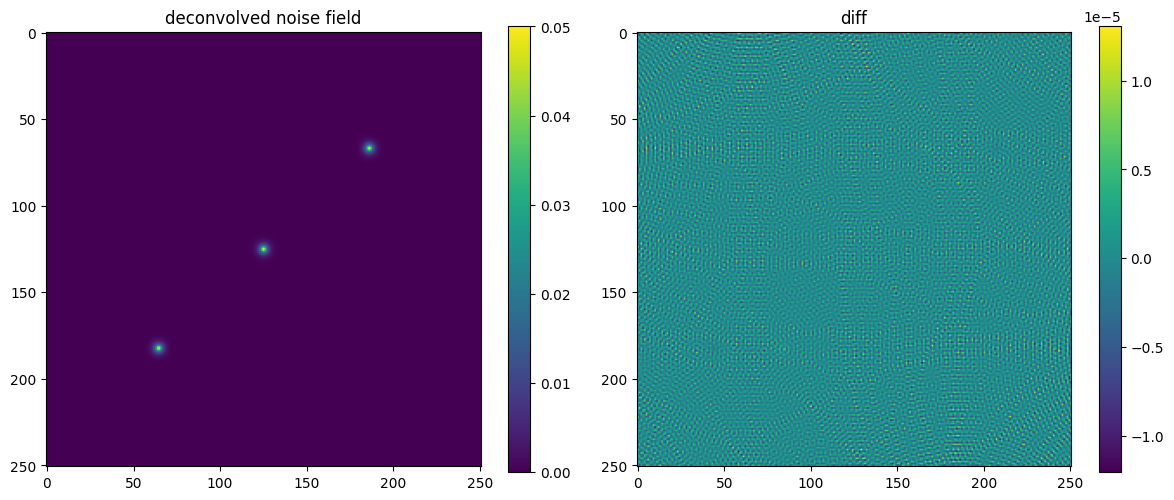

In [12]:
# Compare deconvolved gal field
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(ims_deconvolved)
fig.colorbar(im0, ax=axes[0])
axes[0].set_title("deconvolved noise field")

im1 = axes[1].imshow(ims_deconvolved - ims_deconvolved_numpy)
fig.colorbar(im1, ax=axes[1])
axes[1].set_title("diff")

plt.tight_layout()
plt.show()